# Chuẩn bị các thành phần của chương trình dự đoán

In [ ]:
# @title Mount drive và import các thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import pandas as pd
import pickle
import re
from urllib.parse import unquote

Mounted at /content/drive


In [ ]:
# @title Load các model phát hiện tương ứng dưới dạng nhị phân sử dụng pickle
XSS = pickle.load(open('/content/drive/MyDrive/Machine_Log_Analysis/Model/Model_Results/XSS.sav', 'rb'))
SQLi = pickle.load(open('/content/drive/MyDrive/Machine_Log_Analysis/Model/Model_Results/SQLi.sav', 'rb'))
PT = pickle.load(open('/content/drive/MyDrive/Machine_Log_Analysis/Model/Model_Results/PT.sav', 'rb'))
OS = pickle.load(open('/content/drive/MyDrive/Machine_Log_Analysis/Model/Model_Results/OS.sav', 'rb'))


In [ ]:
# @title Trích xuất các đặc trưng của từng kiểu tấn công ra thành các list
XSS_L, SQLi_L, PT_L, OS_L = [], [], [], []
XSS_L = XSS.feature_names_in_.tolist()
SQLi_L = SQLi.feature_names_in_.tolist()
PT_L = PT.feature_names_in_.tolist()
OS_L = OS.feature_names_in_.tolist()

In [ ]:
# @title Hàm kiểm tra XSS
def XSS_check(url):
  df_temp = pd.DataFrame(columns=XSS_L)
  df_temp.loc[0] = 0
  url = unquote(url)
  url = unquote(url)
  url = url.replace('\n','')
  url = url.replace(' ','')
  url = url.lower()
  for col in XSS_L:
    if col in url:
      df_temp[col] = 1
  return XSS.predict(df_temp)[0]

In [ ]:
# @title Hàm kiểm tra QSLi

def SQLi_check(url):
  df_temp = pd.DataFrame(columns=SQLi_L)
  df_temp.loc[0] = 0
  url = unquote(url)
  url = unquote(url)
  url = url.replace('\n','')
  url = url.lower()
  for col in SQLi_L:
    if col in url:
      df_temp[col] = 1
  return SQLi.predict(df_temp)[0]

In [ ]:
# @title Hàm kiểm tra Path Traversal


def PT_check(url):
  df_temp = pd.DataFrame(columns=PT_L)
  df_temp.loc[0] = 0
  url = unquote(url)
  url = unquote(url)
  url = unquote(url)
  url = unquote(url)
  url = url.replace('\n','')
  url = url.lower()
  for col in PT_L:
    if col in url:
      df_temp[col] = 1
  return PT.predict(df_temp)[0]

In [ ]:
# @title Hàm kiểm tra OS Commanding


def OS_check(url):
  df_temp = pd.DataFrame(columns=OS_L)
  df_temp.loc[0] = 0
  url = unquote(url)
  url = unquote(url)
  url = url.replace('\n',' ')
  url = url.replace('+',' ')
  url = url.lower()
  for col in OS_L:
    if col in url:
      df_temp[col] = 1
  return OS.predict(df_temp)[0]

# Thực hiện phân tích và dự đoán

In [ ]:
# @title Phân tích file log và lưu kết quả vào DataFrame

# @markdown Đường dẫn file log:
log_location = "/content/drive/MyDrive/Machine_Log_Analysis/Predict/test/access_final.log" # @param {"type":"string"}

data = [] #Tạo List chứa dữ liệu đàu ra
exp = r'^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+)\s?(\S+)?\s?(\S+)?" (\d{3}|-) (\d+|-)\s?"?([^"]*)"?\s?"?([^"]*)?"?$' #Regex chia nội dung của input thành các nhóm, trong đó nhóm 6 là URL HTTP


with open(log_location) as log:
    for line in log:
        match = re.match(exp, line) #Kiểm tra xem dòng có hợp format regex không, sau đó nhóm các giá trị phù hợp vào từng nhóm
        if match:
            # Kiểm tra loại tấn công bằng cách sử dụng giá trị của nhóm 6 là phương thức, URL và phiên bản HTTP
            group_6_data = match.group(6)
            if XSS_check(group_6_data):
                attack_type = 'XSS'
            elif SQLi_check(group_6_data):
                attack_type = 'SQLi'
            elif PT_check(group_6_data):
                attack_type = 'PT'
            elif OS_check(group_6_data):
                attack_type = 'OS'
            else:
                attack_type = 'Normal'

            # Thêm dữ liệu vào danh sách, sử dụng từng nhóm cần thiết theo chỉ số
            data.append([match.group(1), match.group(4), match.group(5), match.group(6), match.group(8), attack_type])

df = pd.DataFrame(data, columns=['IP Address', 'Timestamp', 'Method','Request Vector','Response Code','Type'])
df

,IP Address,Timestamp,Method,Request Vector,Response Code,Type
0,192.168.199.1,20/Jun/2021:12:35:40 +0300,GET,/,200,Normal
1,192.168.199.1,20/Jun/2021:12:35:40 +0300,GET,/icons/unknown.gif,200,Normal
2,192.168.199.1,20/Jun/2021:12:35:40 +0300,GET,/icons/layout.gif,200,Normal
3,192.168.199.1,20/Jun/2021:12:35:40 +0300,GET,/icons/folder.gif,200,Normal
4,192.168.199.1,20/Jun/2021:12:35:40 +0300,GET,/icons/text.gif,200,Normal
...,...,...,...,...,...,...
12552,192.168.199.2,20/Jun/2021:12:52:36 +0300,GET,/bWAPP/phpi.php?message=%22%22;%20system(%27wh...,200,Normal
12553,192.168.199.2,20/Jun/2021:12:52:46 +0300,GET,/bWAPP/phpi.php?message=%22%22;%20system(%27ne...,200,Normal
12554,192.168.199.2,20/Jun/2021:12:52:56 +0300,GET,/bWAPP/phpi.php?message=%22%22;%20system(%27ne...,200,Normal
12555,192.168.199.2,20/Jun/2021:12:53:13 +0300,GET,/bWAPP/phpi.php?message=%22%22;%20system(%27ne...,200,Normal


In [ ]:
# @title Xuất DataFrame ra Google Sheets và hiển thị

from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/165Pfph16yILvOYQtQOBv5h75BT7M7USiykV_UOeYdIk#gid=0


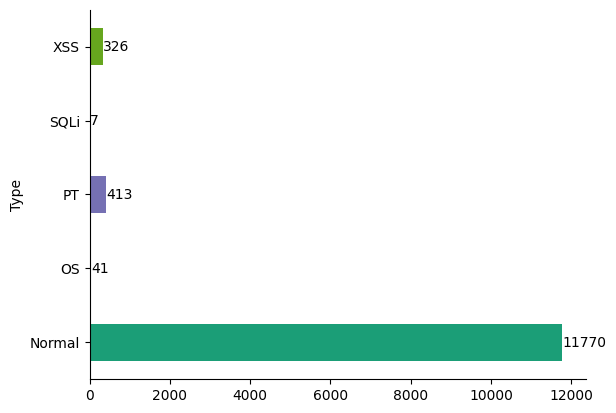

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# Nhóm dữ liệu và tạo biểu đồ
ax = df.groupby('Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

# Tùy chỉnh giao diện biểu đồ
plt.gca().spines[['top', 'right']].set_visible(False)

# Thêm số vào cuối mỗi thanh
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.1,  # Điều chỉnh vị trí để hơi lệch sang phải của thanh
            p.get_y() + p.get_height() / 2, # Căn giữa theo chiều dọc
            str(int(width)),  # Chuyển đổi chiều rộng thành số nguyên và hiển thị dưới dạng văn bản
            ha='left', va='center')  # Căn chỉnh văn bản theo chiều ngang và chiều dọc

plt.show() # Hiển thị biểu đồ với chú thích